In [1]:

import os
#os.environ["XLA_FLAGS"] = (
#    "--xla_gpu_strict_conv_algorithm_picker=false "
#    "--xla_gpu_enable_cudnn_frontend=false "
#    "--xla_gpu_autotune_level=0"
#)
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_PLATFORMS"] = "cuda"  # or: os.environ["JAX_PLATFORM_NAME"]="cuda"
#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


/tmp/ipykernel_3515893/2709273283.py:17: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


In [2]:
#load athena ICs
import h5py
import jax.numpy as jnp
from diffhydro.utils.io import athinput,athdf

athena_outputs_loc = "/gpfs02/work/bhorowitz/sims/blast_mhd/"

ic_filename = "Blast_MHD.out1.00000.athdf"


ICs = athdf(athena_outputs_loc+ic_filename)


In [3]:
#some strange index conventions, need to double check these...
import jax.numpy as jnp
sol = jnp.zeros((8,64,64,64))

sol = sol.at[0].set(ICs["rho"])
sol = sol.at[1].set(ICs["vel2"])
sol = sol.at[2].set(ICs["vel1"])
sol = sol.at[3].set(ICs["vel3"])

sol = sol.at[4].set(ICs["Bcc2"])
sol = sol.at[5].set(ICs["Bcc1"])
sol = sol.at[6].set(ICs["Bcc3"])

sol = sol.at[-1].set(ICs["press"])

2025-10-24 16:07:34.557669: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.6 which is older than the PTX compiler version 12.9.86. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
import diffhydro as dh


In [5]:
eq = dh.equationmanager_mhd.EquationManagerMHD()
#eq = dh.equationmanager.EquationManager()

In [6]:
#%pylab inline
#for i in range(0,8):
#    imshow(sol[i].sum(axis=0))
#    show()

In [7]:
ic = eq.get_conservatives_from_primitives(sol)

In [8]:
#eq = EquationManagerMHD()              # provides get_fast_magnetosonic_speed, get_fluxes_xi (MHD)
#solver = dh.HLLC(equation_manager=eq) # signal_speed not needed here
#cf = dh.ConvectiveFlux(eq, solver, dh.MUSCL3(limiter="VANLEER"))
ss = dh.signal_speed_Rusanov
#solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
solver = dh.HLL_MHD(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"))
hydro = dh.hydro(n_super_step=80, fluxes=[cf], use_mol=True, integrator="SSPRK3")

In [9]:
params = {}
output = hydro.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]


In [10]:
field_out = output[0]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


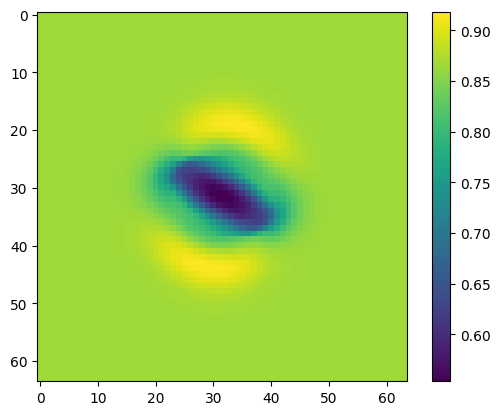

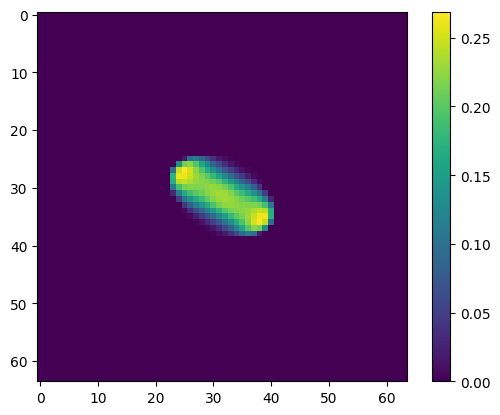

In [11]:
%pylab inline

field_out_prim = eq.get_primitives_from_conservatives(field_out)
imshow(field_out_prim[5][:,:,32])
colorbar()
show()
imshow(field_out_prim[-1][:,:,32])
colorbar()

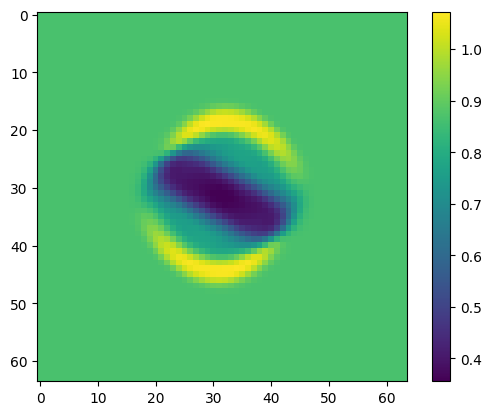

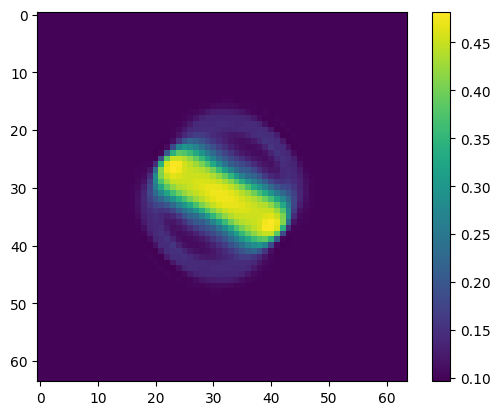

In [12]:

fc_filename = "Blast_MHD.out1.00002.athdf"

FCs = athdf(athena_outputs_loc+fc_filename)
imshow(FCs["Bcc1"][32])
colorbar()
show()
imshow(FCs["press"][32])
colorbar()
show()

In [ ]:
#HLL_MHD is very diffusive! Not surprising... lets use HLLD!

In [13]:
from diffhydro.solver.riemann_solver import RiemannSolver

class HLLD_MHD(RiemannSolver):
    """
    HLLD Riemann solver for ideal MHD (Miyoshi & Kusano, 2005).
    Assumes:
      - Primitives W = [rho, u, v, w, B1, B2, B3, p]
      - Conservatives U = [rho, rho*u, rho*v, rho*w, B1, B2, B3, E]
    Uses safe divisions and HLL fallback for degenerate wave fans.
    """

    def __init__(self, equation_manager, signal_speed=None, **kwargs):
        super().__init__(equation_manager, signal_speed)

    # ---------- helpers ----------
    def _safe_div(self, num, den, eps):
        den_safe = jnp.where(jnp.abs(den) < eps,
                             jnp.where(den >= 0.0, eps, -eps),
                             den)
        return num / den_safe

    def _clamp_pos(self, x, eps):
        return jnp.where(x > eps, x, eps)

    def _pick_axis(self, W, axis, eq):
        """Rotate to 'axis' as the normal direction.
        Returns: un, vt1, vt2, Bn, Bt1, Bt2, and a function to un-rotate (u,v,w,B1,B2,B3)."""
        u_i, v_i, w_i = eq.vel_ids
        Bx_i, By_i, Bz_i = eq.mag_ids

        if axis == 0:
            un, vt1, vt2 = W[u_i], W[v_i], W[w_i]
            Bn, Bt1, Bt2 = W[Bx_i], W[By_i], W[Bz_i]
            def unrotate(un_, vt1_, vt2_, Bn_, Bt1_, Bt2_):
                return (un_, vt1_, vt2_, Bn_, Bt1_, Bt2_)
        elif axis == 1:
            un, vt1, vt2 = W[v_i], W[w_i], W[u_i]
            Bn, Bt1, Bt2 = W[By_i], W[Bz_i], W[Bx_i]
            def unrotate(un_, vt1_, vt2_, Bn_, Bt1_, Bt2_):
                # map back: normal along y
                return (vt2_, un_, vt1_, Bt2_, Bn_, Bt1_)
        else:
            un, vt1, vt2 = W[w_i], W[u_i], W[v_i]
            Bn, Bt1, Bt2 = W[Bz_i], W[Bx_i], W[By_i]
            def unrotate(un_, vt1_, vt2_, Bn_, Bt1_, Bt2_):
                # map back: normal along z
                return (vt1_, vt2_, un_, Bt1_, Bt2_, Bn_)
        return un, vt1, vt2, Bn, Bt1, Bt2, unrotate

    # ---------- core ----------
    def _solve_riemann_problem_xi_single_phase(
        self,
        WL, WR, UL, UR,
        axis: int,
        **kwargs
    ):
        eq = self.equation_manager
        eps = self.eps

        rho_i = eq.mass_ids
        u_i, v_i, w_i = eq.vel_ids
        Bx_i, By_i, Bz_i = eq.mag_ids
        E_i = eq.energy_ids  # expected -1

        # rotate to axis-normal frame
        uL, vt1L, vt2L, BnL, Bt1L, Bt2L, unrot = self._pick_axis(WL, axis, eq)
        uR, vt1R, vt2R, BnR, Bt1R, Bt2R, _     = self._pick_axis(WR, axis, eq)
        rhoL, rhoR = WL[rho_i], WR[rho_i]
        pL,   pR   = WL[E_i],  WR[E_i]

        # total pressure
        B2L = WL[Bx_i]*WL[Bx_i] + WL[By_i]*WL[By_i] + WL[Bz_i]*WL[Bz_i]
        B2R = WR[Bx_i]*WR[Bx_i] + WR[By_i]*WR[By_i] + WR[Bz_i]*WR[Bz_i]
        ptL = pL + 0.5 * B2L
        ptR = pR + 0.5 * B2R

        # fast magnetosonic speeds (normal)
        cfL = eq.get_fast_magnetosonic_speed(WL, axis)
        cfR = eq.get_fast_magnetosonic_speed(WR, axis)

        # outer wave bounds (Davis)
        SL = jnp.minimum(uL - cfL, uR - cfR)
        SR = jnp.maximum(uL + cfL, uR + cfR)
        SR = jnp.maximum(SR, SL)  # enforce ordering
        denom = self._clamp_pos(SR - SL, eps)

        # physical fluxes
        FL = eq.get_fluxes_xi(WL, UL, axis)
        FR = eq.get_fluxes_xi(WR, UR, axis)

        # HLL state and flux (used for fallback and some intermediates)
        UHLL = (SR * UR - SL * UL + (FL - FR)) / denom
        FHLL = (SR * FL - SL * FR + SL * SR * (UR - UL)) / denom

        # choose single Bn* across fan (upwind choice is robust)
        Bn_i = {0: Bx_i, 1: By_i, 2: Bz_i}[axis]
        Bn_star = jnp.where(jnp.abs(SL) > jnp.abs(SR), BnL, BnR)

        # contact speed SM from HLL state
        momn_i = {0: u_i, 1: v_i, 2: w_i}[axis]
        SM = self._safe_div(UHLL[momn_i] - Bn_star * UHLL[Bn_i],
                            UHLL[rho_i], eps)

        # star densities
        rhoL_star = self._clamp_pos(rhoL * self._safe_div(SL - uL, SL - SM, eps), eps)
        rhoR_star = self._clamp_pos(rhoR * self._safe_div(SR - uR, SR - SM, eps), eps)

        # tangential star states (Alfvén jumps)
        def tangential_star(vt1, vt2, Bt1, Bt2, rho, un, S):
            denom_side = self._clamp_pos(rho * (S - SM), eps)
            vt1s = vt1 - Bn_star * Bt1 / denom_side
            vt2s = vt2 - Bn_star * Bt2 / denom_side
            Bt1s = Bt1 * self._safe_div(S - un, S - SM, eps)
            Bt2s = Bt2 * self._safe_div(S - un, S - SM, eps)
            return vt1s, vt2s, Bt1s, Bt2s

        vt1L_s, vt2L_s, Bt1L_s, Bt2L_s = tangential_star(vt1L, vt2L, Bt1L, Bt2L, rhoL, uL, SL)
        vt1R_s, vt2R_s, Bt1R_s, Bt2R_s = tangential_star(vt1R, vt2R, Bt1R, Bt2R, rhoR, uR, SR)

        # conservative star states and star fluxes
        def cons_star(W, U, rho_s, vt1s, vt2s, Bn_s, Bt1s, Bt2s, S):
            # build axis-frame primitives
            un_s = SM
            u_s, v_s, w_s, B1_s, B2_s, B3_s = unrot(un_s, vt1s, vt2s, Bn_s, Bt1s, Bt2s)

            # energy from primitives and fields
            rho_s = self._clamp_pos(rho_s, eps)
            ke = 0.5 * rho_s * (u_s*u_s + v_s*v_s + w_s*w_s)
            me = 0.5 * (B1_s*B1_s + B2_s*B2_s + B3_s*B3_s)
            p  = W[E_i]
            e_int = eq.get_specific_energy(p, rho_s) * rho_s
            E_s = ke + me + e_int

            U_s = jnp.zeros_like(U)
            U_s = U_s.at[rho_i].set(rho_s)
            U_s = U_s.at[u_i].set(rho_s * u_s)
            U_s = U_s.at[v_i].set(rho_s * v_s)
            U_s = U_s.at[w_i].set(rho_s * w_s)
            U_s = U_s.at[Bx_i].set(B1_s)
            U_s = U_s.at[By_i].set(B2_s)
            U_s = U_s.at[Bz_i].set(B3_s)
            U_s = U_s.at[E_i].set(E_s)

            # star flux from side: F* = F + S (U* - U)
            F_side = eq.get_fluxes_xi(W, U, axis)
            F_star = F_side + S * (U_s - U)
            return U_s, F_star

        UL_star, FL_star = cons_star(WL, UL, rhoL_star, vt1L_s, vt2L_s, Bn_star, Bt1L_s, Bt2L_s, SL)
        UR_star, FR_star = cons_star(WR, UR, rhoR_star, vt1R_s, vt2R_s, Bn_star, Bt1R_s, Bt2R_s, SR)

        # select flux by region
        # regions: 0<SL => FL ; SL<=0<SM => FL* ; SM<=0<SR => FR* ; 0>=SR => FR
        flux_sel = jnp.where(0.0 <= SL, FL,
                     jnp.where(0.0 <= SM, FL_star,
                       jnp.where(0.0 < SR, FR_star, FR)))

        # degeneracy detection → fallback to HLL
        degenerate = (jnp.abs(SR - SL) < 100*eps) \
                     | (rhoL_star <= eps) | (rhoR_star <= eps)
        flux = jnp.where(degenerate, FHLL, flux_sel)
 #       flux = jnp.nan_to_num(flux, 0.0, 0.0, 0.0)

        return flux, None, None

In [29]:

#ss = dh.signal_speed_Rusanov #i d
eq.cfl = 0.3
solver = HLLC_MHD(equation_manager=eq,signal_speed=ss)

cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"))
hydro = dh.hydro(n_super_step=120, fluxes=[cf], use_mol=True, integrator="RK2",maxjit=False)

In [30]:
params = {}
output = hydro.evolve(sol,params)

dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, 10000000000.0]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


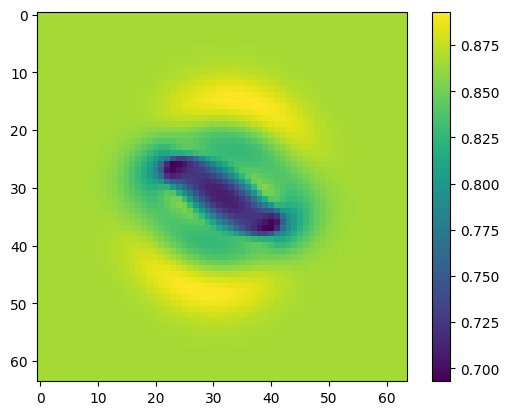

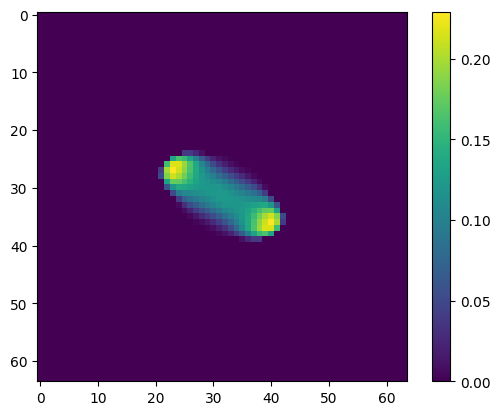

In [31]:
%pylab inline
field_out = output[0]
field_out_prim = eq.get_primitives_from_conservatives(field_out)
imshow(field_out_prim[5][:,:,32])
colorbar()
show()
imshow(field_out_prim[-1][:,:,32])
colorbar()